# 贝叶斯网络应用
贝叶斯网络(Bayesian network)，又称为信念网络(Belief network) ，是一种通过有向无环图(Directed acyclic graph, DAG)表示一组随机变量及其条件依赖概率的概率图模型。
概率图中，节点表示随机变量，有向边表示随机变量间的依赖关系，条件概率表示依赖关系的强度。没有父节点的节点用先验概率表达信息。两个节点若无连接则表示相互独立的随机变量。
贝叶斯网络中的节点可以表示任意问题，丰富的概率表达能力使能较好地处理不确定性信息或问题。贝叶斯网络中所有节点都是可见的，并且节点间的因果关系可以非常直观地观察到。这些特性都使得贝叶斯网络在众多智能系统中有相当重要的应用。


## 数据分析
互联网金融在为金融机构和用户提供诸多便利的同时，也存在着信用风险和欺诈问题。
自2013年年底以来，我国商业银行的贷款率一直偏高。由于我国商业银行个人信贷的部分业务不需要提供担保和抵押，因此个人信贷业务面临较大的信用风险。
个人信贷的信用风险，是网络个人信贷机构和出借人面临的重要风险。个人信贷背景下的信用风险的危害性日益凸显，违约事件背后产生的道德风险也比较普遍。这不仅给信贷机构造成损失，同时也可能导致借贷市场运行效率低下。
因此，金融机构急需通过必要的手段来提高信用风险控制的水平。
信贷机构出借资金给贷款人前，会对贷款人的基本信息和以前的信用状况进行收集，以评估贷款人是否有贷款资格以及贷款额度的上限值，因此信贷机构会积累贷款人的大量基本信息。
本案例中将某贷款机构脱敏后的历史业务数据作为原始数据，在海量的个人信用历史和信息行为的数据基础，采用机器学习技术得出信用模式，能更加准确地预测个人未来的信用表现，能够提高操作的效率，降低授信成本，精确估计消费信贷的风险，为金融机构进行风险预测提供重要的工具。
![1](assets/img.png)

## 数据处理
先对12个表格做预处理（table_i.csv），处理后合并表格（train_data_all.csv），再对合并后的表格进行预处理（train_data_final.csv），可以得到用于建立模型的最终数据。

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [33]:
src_dir = r"dataset"
data_dir = os.path.join(src_dir, '原始数据')

### 数据表处理

In [34]:
def process(data_dir, src_data='train data.tsv', tar_data='train data process.tsv'):
    """
    新字段
    缺失值
    值标注
    独热编码
    异常值
    标准化
    重置索引
    保存结果
    :param data_dir: 
    :param src_data: 
    :param tar_data: 
    :return: 
    """
    dataset = pd.read_csv(os.path.join(data_dir, src_data), sep="\t", header=0)
    # gender字段(根据身份证获取性别 1 男 0 女)
    dataset['gender'] = list(map(lambda x: 1
    if int(str(x)[-2]) % 2 == 1 else 0, dataset['ID_CARD']))
    # LOAN_DAYS
    # 找一个给定日期，得到距离该日期的天数，作为变量:贷款时间
    # 不会说，月初和月未贷款有一定的差异性，因为发工资一般是在月初
    due_date = pd.to_datetime("2017/12/31")
    dataset["LOAN_DATE"] = pd.to_datetime(dataset["LOAN_DATE"])
    dataset["LOAN_DAYS"] = list(
        map(lambda x: (due_date - x).days, dataset["LOAN_DATE"]))

    # 值标注
    # 用字典对特征类别进行标注
    is_local_repalce_dict = {'本地籍': "0", "非本地籍": "1"}
    dataset["IS_LOCAL"] = dataset["IS_LOCAL"].map(is_local_repalce_dict)
    marry_status_dict = {"已婚": "0", "未婚": "1", "离异": "2", "离婚": "2", "其他": "4", "丧偶": "5"}
    dataset["MARRY_STATUS"] = dataset["MARRY_STATUS"].map(marry_status_dict)
    edu_level_dict = {"初中": 0, "高中": 1, "专科及以下": 2, "专科": 2, "本科": 3,
                      "硕士研究生": 4, "博士研究生": 4, "硕士及以上": 4, "其他": 5}
    if dataset["EDU_LEVEL"].dtype != "float64":
        dataset["EDU_LEVEL"] = dataset["EDU_LEVEL"].map(edu_level_dict)

    # 缺失值
    # WORK PROVINCE字段: 归并到“省”(同时实现 维归约)
    # 如110000，11表示省，00，表示市，00 表示区
    # 处理方法:
    # (1)字段非空，取前2位(float->str)
    # (2)字段缺失，按ID_CARD字段前2位(str)
    province = list(map(lambda x, y: y[:2] if np.isnan(x) else str(x)[:2],
                        dataset['WORK_PROVINCE'], dataset['ID_CARD']))
    dataset['WORK_PROVINCE'] = province
    dataset.drop("ID_CARD", axis=1, inplace=True)

    # 独热编码
    # train_data与test data在AGENT字段取值不同，影响独热编码结果
    # train_data有5个样本，test_data有340个样本
    filt_list = ['朋友推荐', '搜索引擎', '应用商店', '社交软件平台',
                 '收到邮件或短信', '第三方贷款平台', '其他', 'DDH_SYNC',
                 '新闻资讯平台', 'orgloan', 'weijinhui']
    dataset = dataset.loc[[
                              True if x not in filt_list else False for x in dataset['AGENT']], :]
    dataset_part = pd.get_dummies(dataset.loc[:, [
                                                     "AGENT", "IS_LOCAL", "WORK_PROVINCE", "MARRY_STATUS"]],
                                  drop_first=True)
    dataset[dataset_part.columns] = dataset_part
    if 'AGENT' in dataset.columns:
        dataset.drop(['AGENT', 'IS_LOCAL', 'WORK_PROVINCE', 'MARRY_STATUS'], axis=1, inplace=True)

    # 异常值处理
    # 可能出现异常值dataset['SALARY']
    dataset['SALARY'].describe()

    # 没有异常值

    # 标准化
    def scalar(series):
        """
        标准化
        :param series: 
        :return: 
        """
        theMean = series.mean()
        theStd = series.std()
        return series.map(lambda x: (x - theMean) / theStd)

    # SALARY LOAN_DAYS EDU_LEVEL
    dataset['SALARY'] = scalar(dataset['SALARY'])
    dataset['LOAN_DAYS'] = scalar(dataset['LOAN_DAYS'])
    dataset['EDU_LEVEL'] = scalar(dataset['EDU_LEVEL'])

    # 重置索引
    dataset.index = dataset.REPORT_ID
    del dataset['REPORT_ID']

    # 当前数据集
    print(dataset.head())

    # 保存结果
    dataset.to_csv(os.path.join(data_dir, tar_data))

### 其他数据表

In [35]:
def process_2(data_dir, src_data='contest_ext_crd_hd_report.csv', tar_data='table_2.csv'):
    """
    其他数据表处理
    :param data_dir: 
    :param src_data: 
    :param tar_data: 
    :return: 
    """
    # table_2
    table_2 = pd.read_csv(os.path.join(data_dir, src_data), sep=',')
    table_2.columns = [str.lower(i) for i in table_2.columns]
    # 子集1
    query_reason_dict = {'担保资格审查': '1', '贷款审批': '2', '贷后管理': '3'}
    table_2['query_reason'] = table_2['query_reason'].map(query_reason_dict)
    type_dw_dummy = pd.get_dummies(table_2[['report_id', 'query_reason']])
    df_query_reason = type_dw_dummy.groupby('report_id').mean()
    df_query_reason.columns = ['report' + i for i in df_query_reason.columns]
    # 子集2
    query_org_dummy = pd.get_dummies(table_2[['report_id', 'query_org']])
    df_query_org_dummy = query_org_dummy.groupby('report_id').mean()
    df_query_org_dummy.columns = ['report ' + i for i in df_query_org_dummy.columns]
    # 合并
    table_2_merge = pd.merge(df_query_reason, df_query_org_dummy,
                             left_index=True, right_index=True)
    # 保存结果
    table_2_merge.to_csv(os.path.join(data_dir, tar_data))

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [37]:
# table_3.csv
def process_3(data_dir,
              src_data='contest_ext_crd_cd_ln.tsv', tar_data='table_3.csv'):
    # table_3
    table_3 = pd.read_csv(os.path.join(data_dir, src_data), sep='\t')
    # table_3.shape
    # table_3.head()

    # 值标注
    # table_3['state'].value_counts()
    state_dict = {'结清': 'JQ', '逾期': 'YQ', '正常': 'NM', '呆账': 'DZ',
                  '转出': 'ZC', '销户': 'XH', '冻结': 'FZ', '止付': 'EP',
                  '未激活': 'IA'}
    table_3['state'] = table_3['state'].map(state_dict)
    # table_3['type_dw'].value_counts()
    type_dw_dict = {'个人经营性贷款': 'PBL', '个人汽车贷款': 'PAL',
                    '个人商用房（包括商住两用）贷款': 'PCHL', '个人消费贷款': 'PCL',
                    '个人住房贷款': 'PHL', '个人住房公积金贷款': 'IHL',
                    '个人助学贷款': 'ILE', '农户贷款': 'FL', '其他贷款': 'OTHERS'}
    table_3['type_dw'] = table_3['type_dw'].map(type_dw_dict)
    # table_3['guarantee_type'].value_counts()
    guarantee_type_dict = {'保证': 'G', '抵押担保': 'G_US', '农户联保': 'G_PL',
                           '其他担保': 'G_OTHERS', '信用/免担保': 'G_NG',
                           '信用免担保': 'G_NG', '质押（含保证金）担保': 'G_PG_IM',
                           '组合（不含保证）担保': 'G_CG_WW',
                           '组合（含保证）担保': 'G_CG_IW'}
    table_3['guarantee_type'] = table_3['guarantee_type'].map(
        guarantee_type_dict)
    # table_3['payment_rating'].value_counts()
    payment_rating_dict = {'按半年归还': 'P_H', '按季归还': 'P_S', '按年归还': 'P_Y',
                           '按其他方式归还': 'P_OHTERS', '按日归还': 'P_D',
                           '按月归还': 'P_M', '按周归还': 'P_W', '不定期归还': 'P_U',
                           '一次性归还': 'P_O'}
    table_3['payment_rating'] = table_3['payment_rating'].map(
        payment_rating_dict)
    # table_3['class5_state'].value_counts()
    class5_state_dict = {'次级': 'C_I', '关注': 'C_F',
                         '可疑': 'C_D', '未知': 'C_U', '正常': 'C_N'}
    table_3['class5_state'] = table_3['class5_state'].map(class5_state_dict)
    # 只划分两种
    # table_3['currency'].value_counts()
    table_3['currency'] = list(
        map(lambda x: 1 if x == '人民币' else 0, table_3['currency']))

    # 归并到report id
    # table_3.isnull().sum()

    # 独热编码
    # 子集1
    state_dummy = pd.get_dummies(table_3[['report_id', 'state']])
    df_state = state_dummy.groupby('report_id').mean()
    # 子集2
    type_dw_dummy = pd.get_dummies(table_3[['report_id', 'type_dw']])
    df_type_dw = type_dw_dummy.groupby('report_id').mean()
    # 子集3
    guarantee_type_dummy = pd.get_dummies(
        table_3[['report_id', 'guarantee_type']])
    df_guarantee_type = guarantee_type_dummy.groupby('report_id').mean()
    # 子集4
    payment_rating_dummy = pd.get_dummies(
        table_3[['report_id', 'payment_rating']])
    df_payment_rating = payment_rating_dummy.groupby('report_id').mean()
    # 子集5
    # 注意，行和不唯一是因为有缺失值，缺失值在转换为虚拟变量时全变成了0
    class5_state_dummy = pd.get_dummies(table_3[['report_id', 'class5_state']])
    df_class5_state = class5_state_dummy.groupby('report_id').mean()
    # 子集6
    df_continuous = table_3.loc[:, ['report_id', 'payment_cyc',
                                    'credit_limit_amount', 'balance',
                                    'remain_payment_cyc',
                                    'scheduled_payment_amount',
                                    'actual_payment_amount', 'curr_overdue_cyc',
                                    'curr_overdue_amount']]
    df_continuous_mean = df_continuous.groupby('report_id').mean()
    # 子集6：标准化+缺失值处理
    ss = StandardScaler()
    columns = df_continuous_mean.columns
    indexs = df_continuous_mean.index
    # 当前sklearn版本：Imputer -> SimpleImputer # Nan -> np.nan # , axis=0
    imr = SimpleImputer(missing_values=np.nan, strategy='mean')
    df_continuous_mean = pd.DataFrame(ss.fit_transform(
        imr.fit_transform(df_continuous_mean.values)))
    df_continuous_mean.columns = columns
    df_continuous_mean.index = indexs
    # 子集7
    # df_currency = table_3.loc[:, ['report_id', 'currency']]\
    #     .groupby('report_id').mean()
    # (df_currency != 1)['currency'].value_counts()# 全为1， 无意义
    # 子集8
    df_count = table_3.loc[:, ['report_id', 'payment_rating']].groupby(
        'report_id').count()
    df_count.columns = ['loan_count']

    # 合并子集
    table_3 = pd.merge(df_state, df_type_dw, left_index=True, right_index=True)
    table_3 = pd.merge(table_3, df_guarantee_type,
                       left_index=True, right_index=True)
    table_3 = pd.merge(table_3, df_payment_rating,
                       left_index=True, right_index=True)
    table_3 = pd.merge(table_3, df_class5_state,
                       left_index=True, right_index=True)
    table_3 = pd.merge(table_3, df_continuous_mean,
                       left_index=True, right_index=True)
    table_3 = pd.merge(table_3, df_count, left_index=True, right_index=True)

    # 保存结果
    table_3.to_csv(os.path.join(data_dir, tar_data))

In [38]:
# table_4.csv
def process_4(data_dir,
              src_data='contest_ext_crd_cd_lnd.tsv', tar_data='table_4.csv'):
    # table_4
    table_4 = pd.read_csv(os.path.join(data_dir, src_data), sep='\t')
    # table_4.loc[:, ['state', 'currency', 'guarantee_type', 'cardtype']].head()
    # table_4.loc[:, ['credit_limit_amount', 'share_credit_limit_amount', 'used_credit_limit_amount', 'latest6_month_used_avg_amount',
    #                 'used_highest_amount', 'scheduled_payment_amount', 'actual_payment_amount', 'curr_overdue_cyc', 'curr_overdue_amount']].head()

    # 值标注
    state_dict = {'结清': 'JQ', '逾期': 'YQ', '正常': 'NM', '呆账': 'DZ',
                  '转出': 'ZC', '销户': 'XH', '冻结': 'FZ', '止付': 'EP',
                  '未激活': 'IA'}
    table_4['state'] = table_4['state'].map(state_dict)
    guarantee_type_dict = {'保证': 'G', '抵押担保': 'G_US', '农户联保': 'G_PL',
                           '其他担保': 'G_OTHERS', '信用/免担保': 'G_NG',
                           '信用免担保': 'G_NG', '质押（含保证金）担保': 'G_PG_IM',
                           '组合（不含保证）担保': 'G_CG_WW',
                           '组合（含保证）担保': 'G_CG_IW'}
    table_4['guarantee_type'] = table_4['guarantee_type'].map(
        guarantee_type_dict)
    table_4['currency'] = list(
        map(lambda x: 1 if x == '人民币' else 0, table_4['currency']))

    # 独热编码
    # （1）
    state_dummy = pd.get_dummies(table_4[['report_id', 'state']])
    df_state = state_dummy.groupby('report_id').mean()
    df_state.columns = ['ind_' + i for i in df_state.columns]
    # （2）
    guarantee_type_dummy = pd.get_dummies(
        table_4[['report_id', 'guarantee_type']])
    df_guarantee_type = guarantee_type_dummy.groupby('report_id').mean()
    df_guarantee_type.columns = ['ind_' + i for i in df_guarantee_type.columns]
    # （3）
    df_count = table_4.loc[:, ['report_id', 'state']
               ].groupby('report_id').count()
    df_count.columns = ['loan_count']
    # （4）
    currency_dummy = table_4[['report_id', 'currency']]
    df_currency = currency_dummy.groupby('report_id').mean()
    df_currency.columns = ['ind_' + i for i in df_currency.columns]
    # （5）
    df_continuous = table_4.loc[:,
                    ['report_id', 'credit_limit_amount',
                     'share_credit_limit_amount',
                     'used_credit_limit_amount',
                     'latest6_month_used_avg_amount',
                     'used_highest_amount', 'scheduled_payment_amount',
                     'actual_payment_amount', 'curr_overdue_cyc',
                     'curr_overdue_amount']]
    df_continuous_mean = df_continuous.groupby('report_id').mean()
    ss = StandardScaler()
    columns = df_continuous_mean.columns
    indexs = df_continuous_mean.index
    imr = SimpleImputer(missing_values=np.nan, strategy='mean')
    df_continuous_mean = pd.DataFrame(ss.fit_transform(
        imr.fit_transform(df_continuous_mean.values)))
    df_continuous_mean.columns = columns
    df_continuous_mean.index = indexs

    # 合并子集
    table_4 = pd.merge(df_state, df_guarantee_type,
                       left_index=True, right_index=True)
    table_4 = pd.merge(table_4, df_count, left_index=True, right_index=True)
    table_4 = pd.merge(table_4, df_currency, left_index=True, right_index=True)
    table_4 = pd.merge(table_4, df_continuous_mean,
                       left_index=True, right_index=True)

    # 保存结果
    table_4.to_csv(os.path.join(data_dir, tar_data))

In [39]:
# table_5.csv
def process_5(data_dir,
              src_data='contest_ext_crd_is_creditcue.csv', tar_data='table_5.csv'):
    # table_5
    table_5 = pd.read_csv(os.path.join(data_dir, src_data), sep=',')
    table_5.columns = [str.lower(i) for i in table_5.columns]  # 字符转化为小写
    # 子集
    df_continuous_mean = table_5.loc[:,
                         ['house_loan_count', 'commercial_loan_count',
                          'other_loan_count', 'loancard_count',
                          'standard_loancard_count', 'announce_count',
                          'dissent_count']]
    df_continuous_mean.index = table_5['report_id']
    ss = StandardScaler()
    columns = df_continuous_mean.columns
    indexs = df_continuous_mean.index
    imr = SimpleImputer(missing_values=np.nan, strategy='mean')
    df_continuous_mean = pd.DataFrame(ss.fit_transform(
        imr.fit_transform(df_continuous_mean.values)))
    df_continuous_mean.columns = columns
    df_continuous_mean.index = indexs
    # 保存结果
    df_continuous_mean.to_csv(os.path.join(data_dir, tar_data))

In [40]:
# table_6.csv
def process_6(data_dir,
              src_data='contest_ext_crd_is_sharedebt.csv', tar_data='table_6.csv'):
    # table_6
    table_6 = pd.read_csv(os.path.join(data_dir, src_data), sep=',')
    table_6.columns = [str.lower(i) for i in table_6.columns]
    # 值标注
    type_dw_dict = {'未销户贷记卡信息汇总': 'DJK', '未结清贷款信息汇总': 'DK',
                    '未销户准贷记卡信息汇总': 'ZDJK'}
    table_6['type_dw'] = table_6['type_dw'].map(type_dw_dict)
    # 子集1
    type_dw_dummy = pd.get_dummies(table_6[['report_id', 'type_dw']])
    df_type_dw = type_dw_dummy.groupby('report_id').mean()
    df_type_dw.columns = ['sharedebt_' + i for i in df_type_dw.columns]
    # 子集2
    df_continuous_mean = table_6.drop(['type_dw'], axis=1)
    df_continuous_mean = df_continuous_mean.groupby('report_id').mean()
    ss = StandardScaler()
    columns = df_continuous_mean.columns
    indexs = df_continuous_mean.index
    imr = SimpleImputer(missing_values=np.nan, strategy='mean')
    df_continuous_mean = pd.DataFrame(ss.fit_transform(
        imr.fit_transform(df_continuous_mean.values)))
    df_continuous_mean.columns = columns
    df_continuous_mean.index = indexs
    # 合并子集
    table_6 = pd.merge(df_type_dw, df_continuous_mean,
                       left_index=True, right_index=True)
    # 保存结果
    table_6.to_csv(os.path.join(data_dir, tar_data))

In [41]:
# table_7.csv
def process_7(data_dir,
              src_data='contest_ext_crd_is_ovdsummary.csv', tar_data='table_7.csv'):
    # table_7
    table_7 = pd.read_csv(os.path.join(data_dir, src_data), sep=',')
    table_7.columns = [str.lower(i) for i in table_7.columns]
    # 值标注
    type_dw_dict = {'贷款逾期': 'DQ', '贷记卡逾期': 'DJK',
                    '准贷记卡60天以上透支': 'ZDJK'}
    table_7['type_dw'] = table_7['type_dw'].map(type_dw_dict)
    # 子集1
    type_dw_dummy = pd.get_dummies(table_7[['report_id', 'type_dw']])
    df_type_dw = type_dw_dummy.groupby('report_id').mean()
    df_type_dw.columns = ['ovdsummary_' + i for i in df_type_dw.columns]
    # 子集2
    df_continuous_mean = table_7.drop(['type_dw'], axis=1)
    df_continuous_mean = df_continuous_mean.groupby('report_id').mean()
    ss = StandardScaler()
    columns = df_continuous_mean.columns
    indexs = df_continuous_mean.index
    imr = SimpleImputer(missing_values=np.nan, strategy='mean')
    df_continuous_mean = pd.DataFrame(ss.fit_transform(
        imr.fit_transform(df_continuous_mean.values)))
    df_continuous_mean.columns = columns
    df_continuous_mean.index = indexs
    # 合并子集
    table_7 = pd.merge(df_type_dw, df_continuous_mean,
                       left_index=True, right_index=True)
    # table_7.shape
    # 保存结果
    table_7.to_csv(os.path.join(data_dir, tar_data))

In [42]:
# table_8.csv
def process_8(data_dir,
              src_data='contest_ext_crd_qr_recordsmr.tsv', tar_data='table_8.csv'):
    # table_8
    table_8 = pd.read_csv(os.path.join(data_dir, src_data), sep='\t')
    table_8.columns = [str.lower(i) for i in table_8.columns]
    # 子集1
    table_8['type_id'] = table_8.type_id.astype('str')
    type_dw_dummy = pd.get_dummies(table_8[['report_id', 'type_id']])
    df_query_reason = type_dw_dummy.groupby('report_id').mean()
    df_query_reason.columns = ['recordsmr_' +
                               i for i in df_query_reason.columns]
    # 子集2
    df_continuous_mean = table_8.loc[:, ['report_id', 'sum_dw']]
    df_continuous_mean = df_continuous_mean.groupby('report_id').mean()
    ss = StandardScaler()
    columns = df_continuous_mean.columns
    indexs = df_continuous_mean.index
    imr = SimpleImputer(missing_values=np.nan, strategy='mean')
    df_continuous_mean = pd.DataFrame(ss.fit_transform(
        imr.fit_transform(df_continuous_mean.values)))
    df_continuous_mean.columns = columns
    df_continuous_mean.index = indexs
    # 合并子集
    table_8 = pd.merge(df_query_reason, df_continuous_mean,
                       left_index=True, right_index=True)
    # 保存结果
    table_8.to_csv(os.path.join(data_dir, tar_data))

In [43]:
# table_9.csv
def process_9(data_dir,
              src_data='contest_ext_crd_qr_recorddtlinfo.tsv', tar_data='table_9.csv'):
    # table_9
    pass

In [44]:
# table_10.csv
def process_10(data_dir,
               src_data='contest_ext_crd_cd_ln_spl.tsv', tar_data='table_10.csv'):
    # table_10
    table_10 = pd.read_csv(os.path.join(data_dir, src_data), sep='\t')
    table_10.columns = [str.lower(i) for i in table_10.columns]
    # 值标注
    # table_10.type_dw.value_counts()
    type_dw_dict = {'提前还款（全部）': '1', '提前还款（部分）': '2', '其他': '3',
                    '展期（延期）': '4', '担保人代还 ': '5'}
    table_10['type_dw'] = table_10['type_dw'].map(type_dw_dict)
    # 子集1
    type_dw_dummy = pd.get_dummies(table_10[['report_id', 'type_dw']])
    df_type_dw = type_dw_dummy.groupby('report_id').mean()
    df_type_dw.columns = ['spl_' + i for i in df_type_dw.columns]
    # 子集2
    df_continuous_mean = table_10.loc[:, [
                                             'report_id', 'changing_months', 'changing_amount']]
    df_continuous_mean = df_continuous_mean.groupby('report_id').mean()
    ss = StandardScaler()
    columns = df_continuous_mean.columns
    indexs = df_continuous_mean.index
    imr = SimpleImputer(missing_values=np.nan, strategy='mean')
    df_continuous_mean = pd.DataFrame(ss.fit_transform(
        imr.fit_transform(df_continuous_mean.values)))
    df_continuous_mean.columns = columns
    df_continuous_mean.index = indexs
    # 合并子集
    table_10 = pd.merge(df_type_dw, df_continuous_mean,
                        left_index=True, right_index=True)
    # 保存结果
    table_10.to_csv(os.path.join(data_dir, tar_data))

In [45]:
# table_11.csv
def process_11(data_dir,
               src_data='contest_ext_crd_cd_lnd_ovd.csv', tar_data='table_11.csv'):
    # table_11
    table_11 = pd.read_csv(os.path.join(data_dir, src_data), sep=',')
    table_11.columns = [str.lower(i) for i in table_11.columns]
    # 子集
    df_continuous_mean = table_11.loc[:, [
                                             'report_id', 'last_months', 'amount']]
    df_continuous_mean = df_continuous_mean.groupby('report_id').mean()
    ss = StandardScaler()
    columns = df_continuous_mean.columns
    indexs = df_continuous_mean.index
    imr = SimpleImputer(missing_values=np.nan, strategy='mean')
    df_continuous_mean = pd.DataFrame(ss.fit_transform(
        imr.fit_transform(df_continuous_mean.values)))
    df_continuous_mean.columns = columns
    df_continuous_mean.index = indexs
    # 保存结果
    df_continuous_mean.to_csv(os.path.join(data_dir, tar_data))

In [46]:
process(data_dir, src_data='train_data.tsv', tar_data='train_data_process.csv')
process(data_dir, src_data='test_data.tsv', tar_data='test_data_process.csv')

process_2(data_dir, src_data='contest_ext_crd_hd_report.csv',
          tar_data='table_02.csv')
process_3(data_dir, src_data='contest_ext_crd_cd_ln.tsv',
          tar_data='table_03.csv')
process_4(data_dir, src_data='contest_ext_crd_cd_lnd.tsv',
          tar_data='table_04.csv')
process_5(data_dir, src_data='contest_ext_crd_is_creditcue.csv',
          tar_data='table_05.csv')
process_6(data_dir, src_data='contest_ext_crd_is_sharedebt.csv',
          tar_data='table_06.csv')
process_7(data_dir, src_data='contest_ext_crd_is_ovdsummary.csv',
          tar_data='table_07.csv')
process_8(data_dir, src_data='contest_ext_crd_qr_recordsmr.tsv',
          tar_data='table_08.csv')
# pass
# process_9(data_dir, src_data='contest_ext_crd_qr_recorddtlinfo.tsv', tar_data='table_09.csv')
process_10(data_dir, src_data='contest_ext_crd_cd_ln_spl.tsv',
           tar_data='table_10.csv')
process_11(data_dir, src_data='contest_ext_crd_cd_lnd_ovd.csv',
           tar_data='table_11.csv')

           LOAN_DATE  EDU_LEVEL    SALARY  HAS_FUND  Y  gender  LOAN_DAYS  \
REPORT_ID                                                                   
8787      2017-02-15   1.150666 -0.437004       0.0  0       1   2.090720   
9410      2017-03-13        NaN  1.683545       1.0  0       0   1.469206   
22999     2017-02-27   0.035399  0.269846       0.0  0       1   1.803868   
24820     2017-02-24   0.035399 -1.143853       0.0  1       0   1.875581   
25708     2017-01-16   0.035399       NaN       1.0  0       0   2.807851   

           AGENT_bestpay  AGENT_chinapnr  AGENT_fenqile  ...  \
REPORT_ID                                                ...   
8787               False           False          False  ...   
9410               False           False          False  ...   
22999              False           False          False  ...   
24820              False           False          False  ...   
25708              False           False          False  ...   

           

### 多表合并
每张表预处理完毕后，通过report_id属性将table_i.csv合并成一张表train_all.csv

In [47]:
def merge_tbl(data_dir, src_data='train_data_process.csv', tar_data='train_data'):
    """
    多表合并
    :param data_dir: 
    :param src_data: 
    :param tar_data: 
    :return: 
    """
    dataset = pd.read_csv(os.path.join(data_dir, src_data), index_col=0)
    tbl_list = sorted([tbl_name for tbl_name in os.listdir(
        data_dir) if tbl_name.startswith('table')])
    for tbl in tbl_list:
        try:
            tbl = pd.read_csv(os.path.join(data_dir, tbl)
                              , index_col=0)
            dataset = pd.merge(dataset, tbl, how='left', left_index=True, right_index=True)
        except Exception as e:
            print(tbl, e, sep='\n')
    
    # 观察结果
    dataset.head()
    dataset.describe()
    
    dataset.to_csv(os.path.join(data_dir, f'{tar_data}_all.csv'))

In [48]:
merge_tbl(data_dir, src_data='train_data_process.csv', tar_data='train_data')
merge_tbl(data_dir, src_data='test_data_process.csv', tar_data='test_data')

In [49]:
def process_final(data_dir, src_data='train_data_process.csv', tar_data='train_data'):
    """
    最终处理
    合并完毕后，将对合并的数据进行最终的预处理，包括去除空值、去除非重要信息。
    :param data_dir: 
    :param src_data: 
    :param tar_data: 
    :return: 
    """
    dataset = pd.read_csv(os.path.join(data_dir, src_data), index_col=0)
    dataset = dataset.drop(['LOAN_DATE'], axis=1)
    dataset = dataset.dropna(axis=1, how='all')
    columns = dataset.columns
    imr = SimpleImputer(missing_values=np.nan, strategy='mean')
    dataset = pd.DataFrame(imr.fit_transform(dataset.values))
    dataset.columns = columns
    dataset.to_csv(os.path.join(data_dir, f'{tar_data}_final.csv'))

In [50]:
process_final(data_dir, src_data='train_data_process.csv', tar_data='train_data')
process_final(data_dir, src_data='test_data_process.csv', tar_data='test_data')

## 构建模型

### Logistic 回归模型
Logistic回归模型在两分类问题中具有非常广泛的应用，它能将待分类样本的类别分成两类，是该模型的核心是通过Sigmoid函数将因变量的值转换成概率。但该模型在分类的精准度上有一定欠缺，容易产生过拟合的现象。同时，Logistic回归模型通常用来处理两分类问题，不能很好地处理多分类的情况。而对贷款违约行为进行预测正是贷款是否逾期的两分类问题，比较适合Logistic回归模型处理。

In [51]:
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

In [52]:
src_dir = r'dataset'
data_dir = os.path.join(src_dir, '原始数据')

#### 对应模块
- trans_dataset
- save_txt
- draw_auc
- draw_cm

In [53]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import auc, roc_curve

In [54]:
def trans_dataset(data_dir, src_data='train_data_final.csv'):
    """
    划分数据
    训练集&验证集: train_test_split
    测试集: test_data_final
    :param data_dir: 
    :param src_data: 
    :return: x_train, x_test, y_train, y_test, x_train_st, y_train_st, x_train_st_tiny, x_test_st_tiny
    """
    dataset = pd.read_csv(os.path.join(data_dir, src_data), index_col=0)
    X = dataset.drop(['Y'], axis=1).values
    Y = np.array(dataset['Y'])
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

    # 非平衡数据处理，旨在获得边界清晰且平衡的数据集
    # SMOTE (增加少数类样本) +TOMEK (删除不符合要求的多数类样本)
    data_pairs = [(x_train, x_test, y_train, y_test)]
    st = SMOTETomek(random_state=0)
    x_train_st, y_train_st = st.fit_resample(x_train, y_train)

    # 基于重要性权重选择特征的元变换器
    sfm = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear', C=1.0))
    sfm.fit(x_train, y_train)
    x_train_tiny = sfm.transform(x_train)
    x_test_tiny = sfm.transform(x_test)
    sfm.fit(x_train_st, y_train_st)
    x_train_st_tiny = sfm.transform(x_train_st)
    x_test_st_tiny = sfm.transform(x_test)  # shape: (8999，44)
    return x_train, x_test, y_train, y_test, x_train_st, y_train_st, x_train_st_tiny, x_test_st_tiny

In [55]:
def save_txt(x_test_st_tiny, y_test, y_pred, y_proba, src_dir, txt_name='GaussianNB.txt'):
    """
    保存txt文件
    :param x_test_st_tiny: 
    :param y_test: 
    :param y_pred: 
    :param y_proba: 
    :param src_dir: 
    :param txt_name: 
    :return: save file
    """
    col = np.arange(x_test_st_tiny.shape[0])
    np.savetxt(fname=os.path.join(src_dir, txt_name),
               X=(col, y_test, y_pred, y_proba))
    data = np.genfromtxt(fname=os.path.join(src_dir, txt_name))
    # 转置
    transpose_data = np.transpose(data)
    np.savetxt(fname=os.path.join(src_dir, txt_name), X=transpose_data,
               fmt="%d %d %d %0.10f ", delimiter='\n', newline="\n")

In [56]:
def draw_auc(y_true, y_proba, title="GaussianNB with L1 Penalty", png_name="GaussianNB_auc.png", lw=2):
    """
    AUC曲线
    :param y_true: 
    :param y_proba: 
    :param title: 
    :param png_name: 
    :param w: 
    :param lw: 
    :return: 
    """
    fpr, tpr, _ = roc_curve(y_true, y_proba, pos_label=1)
    auc_value = auc(fpr, tpr)
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title}(area={auc_value:.2%})')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(src_dir, png_name), dpi=800)
    plt.show()

In [57]:
def draw_cm(y_true, y_pred, title="GaussianNB with L1 Penalty", png_name="GaussianNB_cm.png", labels=[0, 1]):
    """
    混淆矩阵
    :param y_true: 
    :param y_pred: 
    :param title: 
    :param png_name: 
    :param labels: 
    :return: 
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    score = accuracy_score(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    plt.matshow(cm, fignum=0, cmap=plt.cm.Reds)
    plt.colorbar()
    for x in range(len(cm)):
        for y in range(len(cm)):
            plt.annotate(cm[x, y], xy=(x, y), fontsize=10.5,
                         horizontalalignment='center',
                         verticalalignment='center')
    plt.xlabel('True Class', fontsize=10.5)
    plt.ylabel('Pred class', fontsize=10.5)
    plt.title(f"{title}(score={score:.2%})", fontsize=12)
    plt.savefig(os.path.join(src_dir, png_name))
    plt.show()

In [58]:
x_train, x_test, y_train, y_test, \
    x_train_st, y_train_st, x_train_st_tiny, x_test_st_tiny = \
    trans_dataset(data_dir, src_data='train_data_final.csv')

model_2 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
model_2.fit(x_train_st_tiny, y_train_st)
y_pred = model_2.predict(x_test_st_tiny)
y_proba = model_2.predict_proba(x_test_st_tiny)[:, 1]

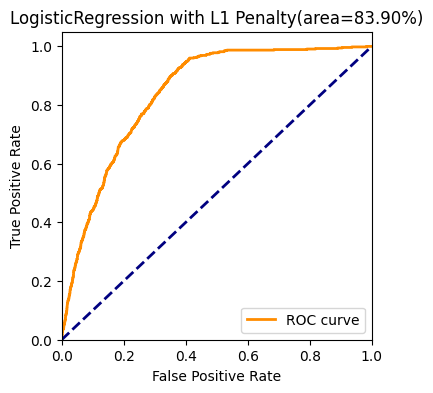

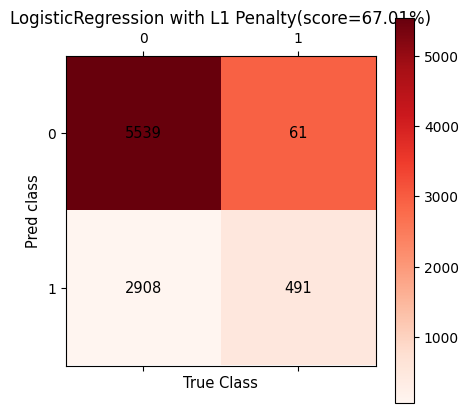

In [59]:
save_txt(x_test_st_tiny, y_test, y_pred, y_proba, src_dir, txt_name='LogisticRegression.txt')
draw_auc(y_test, y_proba, title="LogisticRegression with L1 Penalty", png_name="LogisticRegression_auc.png")
draw_cm(y_test, y_pred, title="LogisticRegression with L1 Penalty", png_name="LogisticRegression_cm.png")

### 朴素贝叶斯
朴素贝叶斯模型假设每个特征对分类变量的影响是独立的，这使得分类的联合条件概率很容易计算。
其在信用评估方面得到了广泛的应用。因为在信用评估中，多数变量的属性为标称变量，并且原始数据存在较多的空值，而朴素贝叶斯主要对标称数据进行分析，对空值又不太敏感，因此，选择该分类器对贷款违约行为进行预测。

In [60]:
from sklearn.naive_bayes import GaussianNB

In [61]:
model_1 = GaussianNB()
model_1.fit(x_train_st_tiny, y_train_st)
y_pred = model_1.predict(x_test_st_tiny)
y_proba = model_1.predict_proba(x_test_st_tiny)[:, 1]

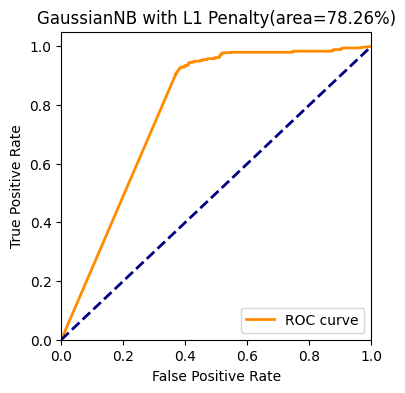

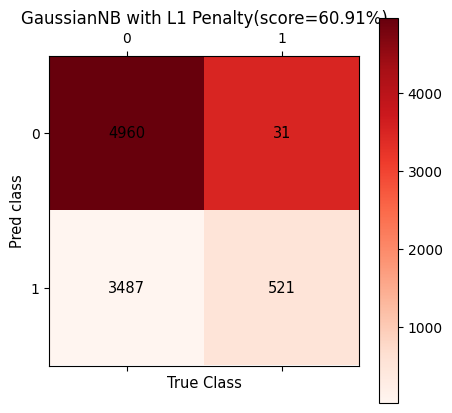

In [62]:
save_txt(x_test_st_tiny, y_test, y_pred, y_proba, src_dir, txt_name='GaussianNB.txt')
draw_auc(y_test, y_proba, title='GaussianNB with L1 Penalty', png_name="GaussianNB_auc.png")
draw_cm(y_test, y_pred, title="GaussianNB with L1 Penalty", png_name="GaussianNB_cm.png")